In [1]:
%load_ext autotime
import warnings; warnings.filterwarnings('ignore')

In [2]:
import pandas as pd, numpy as np, weakref, pickle, math, matplotlib.pyplot as plt, os
from scipy.cluster.hierarchy import dendrogram, fcluster
from collections import defaultdict
from pathlib import Path

time: 330 ms


In [3]:
def entropy(y):
    if len(y) == 0:
        return 1.0
    p = pd.Series(y).value_counts()
    fp = p/np.nansum(p)
    return -np.nansum(fp * np.log(fp))

def normalized_mutual_information(a, b):
    la = float(len(a))
    lb = float(len(b))
    ha = entropy(a)
    hb = entropy(b)
    a = pd.Series(a).value_counts()
    b = pd.Series(b).value_counts()
    c = pd.concat([a, b], axis=1).fillna(0.0).min(axis=1)
    fa = a/la
    fb = b/lb
    fc = c/(la+lb)
    mi = np.nansum(fc*np.log((fc/(fa*fb))))
    nmi = 2*mi/(ha*hb) 
    return nmi

time: 7.4 ms


In [4]:
class Linkage:
    factor = 1
    def __init__(self, nrows):
        self.nrows = nrows
        self.linkage_matrix = np.zeros((self.nrows-1, 4))

    def form_linkage(self, cluster1, cluster2, distance, npoints, row):
        self.linkage_matrix[row] = [cluster1, cluster2, distance*Linkage.factor, npoints]
        
class Cluster:
    count = 0
    _instances = defaultdict()
    nmax = 0

    def __init__(self, key=None, seq=None):
        self._id = Cluster.count
        self.initID = self._id
        Cluster.count += 1
        Cluster.nmax += 1
        self.members = dict()
        self._instances[self.initID] = weakref.ref(self)
        self.factor = 1
        if key is not None:
            self.new_member(key, seq)

    def erase(self):
        Cluster._instances.pop(self.initID, None)

    def incrementFactor(self, factor=1):
        self.factor += factor

    def new_member(self, key, seq):
        self.members[key] = seq

    def updateID(self, iteration):
        self._id = Cluster.nmax + iteration

    @property
    def num_members(self):
        return len(self.members.keys())

    @property
    def get_data(self):
        return [self.members[key] for key in self.members.keys()]
    
    @staticmethod
    def jaccard_coefficient(a, b):
        a = set(a)
        b = set(b)
        common = a.intersection(b)
        union = a.union(b)
        coeff = float(len(common))/len(union)
        return coeff

    @classmethod
    def find_cluster(cls, idx):
        obj = cls._instances[idx]()
        return obj

    @classmethod
    def initial_distance_matrix(cls):       
        cls.distMatrix = np.ones((cls.count, cls.count))
        for i in range(cls.count):
            for j in range(i, cls.count):
                similarity = cls.jaccard_coefficient(cls.find_cluster(i).get_data[0], \
                                                     cls.find_cluster(j).get_data[0])
                cls.distMatrix[i, j] = cls.distMatrix[j, i] = similarity
                
    @classmethod
    def number_of_clusters(cls):
        return len(cls._instances.keys())

    @classmethod
    def smallest_distance(cls):
        minimum_distance, A, B = np.Infinity, None, None
        for i in range(0, cls.distMatrix.shape[0]-1):
            for j in range(i+1, cls.distMatrix.shape[1]):
                if cls.distMatrix[i, j] < minimum_distance:
                    minimum_distance = cls.distMatrix[i, j]
                    A = i
                    B = j
        return A, B, minimum_distance

    @classmethod
    def combine_clusters(cls, merge, delete, iteration, dist, method = 'single'):
        delCluster = cls.find_cluster(delete)
        del_id = delCluster._id
        mergedCluster = cls.find_cluster(merge)
        merge_id = mergedCluster._id
        stacked = np.vstack((cls.distMatrix[merge, :], cls.distMatrix[delete, :]))
        summ = np.array([np.nanmax(stacked, axis=0) if method == 'complete' \
                                                  else np.nanmin(stacked, axis=0)])
        cls.distMatrix[merge, :] = cls.distMatrix[:, merge] = summ
        cls.distMatrix[delete, :] = cls.distMatrix[:, delete] = 1*np.Infinity

        for key in delCluster.members.keys():
            mergedCluster.new_member(key, delCluster.members[key])
            
        mergedCluster.updateID(iteration)
        mergedCluster.incrementFactor()
        delCluster.erase()
        
        return merge_id, del_id, mergedCluster.num_members, mergedCluster.factor

time: 91.7 ms


In [5]:
class HeirarchicalClustering():
    def __init__(self, data, method = 'complete'):
        self.data = data
        self.method = method
        
    def get_linkage(self):
        clusters = [Cluster(idx, self.data[idx]) for idx in self.data.index]
        Cluster.initial_distance_matrix()
        link = Linkage(len(clusters))
        iteration = 0
        while(Cluster.number_of_clusters() >= 2):
            row, col, dist = Cluster.smallest_distance()
            newID, oldID, pts, factor = Cluster.combine_clusters(min(row, col), \
                                        max(row, col), iteration, dist, method=self.method)
            link.form_linkage(oldID, newID, dist, pts, iteration)
            iteration += 1
        self.linkage = link.linkage_matrix
        return self
    
    def plot_dendrogram(self, ax=None, p=10, D=50):
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        dendrogram(self.linkage, ax=ax, orientation="top", show_leaf_counts = True, \
                   show_contracted = True, truncate_mode = 'lastp', p = p)
        ax.axhline(D, color = 'k', ls = '-.')
        ax.tick_params(axis='x', which='both', bottom='off', top='off', left='off')
        ax.set_title("Heirarchical Clustering - " + self.method)
        ax.set_ylabel('Jaccard Similarity')
        return ax        

time: 105 ms


In [6]:
data = pd.read_csv('./AAAI.csv')
data['Topics'] = data['Topics'].apply(lambda x: x.split('\n'))

time: 123 ms


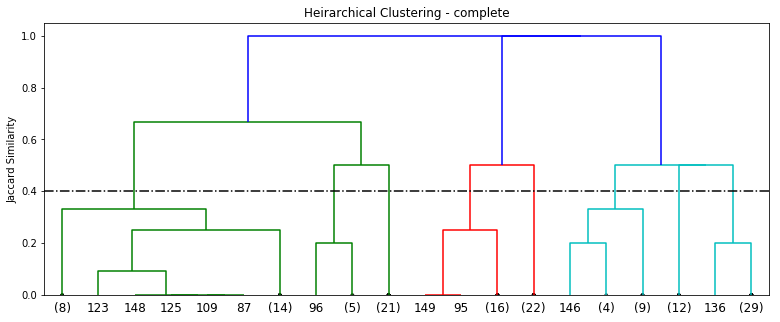

time: 5.66 s


In [7]:
cluster = HeirarchicalClustering(data['Topics'], method = 'complete').get_linkage()
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
cluster.plot_dendrogram(ax=ax, p=20, D=0.4)
plt.savefig('heirarchical_clustering_complete.png', dpi=900)
plt.show()

In [8]:
data['predicted labels'] = fcluster(cluster.linkage, 8, criterion = "maxclust")-1
data

,Title,Keywords,Topics,High-Level Keyword(s),Abstract,predicted labels
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,"[Auctions and Market-Based Systems, E-Commerce...",Multiagent Systems,We introduce a sealed bid auction of a single ...,7
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,"[Dimension Reduction/Feature Selection, Online...",Machine Learning,This paper presents a new approach to basis ad...,7
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,"[Coordination and Collaboration, Game Theory]",Multiagent Systems,Representation languages for coalitional game...,4
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,"[Heuristic Search, Evaluation and Analysis (Se...",Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...,7
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,"[Auctions and Market-Based Systems, E-Commerce...",Multiagent Systems,We propose a new market design for display adv...,4
5,Gradient Networks for Shape-Based Object Insta...,object detection\ninstance detection\nshape\ng...,"[Vision, Object Recognition, and Perception]",Robotics,We present a novel framework for shape-based t...,7
6,Unified Constraint Propagation on Multi-View Data,pairwise constraint propagation\nsemi-supervis...,"[Relational/Graph-Based Learning, Semisupervis...",Machine Learning,This paper presents a unified framework for in...,7
7,Progression of Decomposed Situation Calculus T...,reasoning about actions\ndecomposition of logi...,"[Action, Change, and Causality]",Knowledge Representation and Reasoning,In many tasks related to reasoning about conse...,7
8,How to Cut a Cake Before the Party Ends,Cake cutting\nFair division\nComputational soc...,"[Mechanism Design, Social Choice / Voting]",Multiagent Systems,For decades researchers have struggled with th...,2
9,Reciprocal Hash Tables for Nearest Neighbor Se...,locality sensitive hashing\nnearest neighbor s...,"[Search (General/Other), Information Retrieval...",Machine Learning,Recent years have witnessed the success of has...,4


time: 55.4 ms
